In [ ]:
# @title Ячейка 1: Импорты и загрузка данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    df_class = pd.read_csv('Loan_Default.csv')
    df_reg = pd.read_csv('Car_Sales.csv')
    print("Данные успешно загружены.")
except Exception as e:
    print(f"Ошибка загрузки: {e}")

Данные успешно загружены.


Подготавливаю данные для бейзлайна решающих деревьев.

Я не использую масштабирование StandardScaler, так как алгоритм построения дерева основан на пороговых правилах вида $x_j > t$, и ему не важен абсолютный масштаб признаков, только их порядок (инвариантность к монотонным преобразованиям).

Заполняю пропуски (так как реализация в sklearn не умеет работать с NaN) и кодирую категории через LabelEncoder. Это допустимо для деревьев: даже если кодировка вводит ложный порядок ($A=0, B=1, C=2$), дерево способно изолировать категорию $B$ через комбинацию сплитов (например, $x \ge 1$ и $x < 2$).

In [ ]:
# @title Ячейка 2: Препроцессинг для Бейзлайна (Деревья)
# Здесь я не использую StandardScaler. Деревьям инвариантен масштаб признаков. Но я использую LabelEncoder, так как реализация в sklearn (CART) не умеет нативно работать с категориямистроками
# 1. Классификация (Loan Default)
# Берем семпл для скорости экспериментов
df_class_sample = df_class.sample(frac=0.2, random_state=42).copy()
df_class_sample = df_class_sample.drop(columns=['ID', 'year'], errors='ignore')

X_cls = df_class_sample.drop(columns=['Status'])
y_cls = df_class_sample['Status']

# Заполнение пропусков (Деревья в sklearn не любят NaN)
# Для деревьев можно заполнять пропуски экстремальным значением (-999),
# чтобы дерево выделило их в отдельную ветку, но для бейзлайна возьму медиану/моду
num_cols_cls = X_cls.select_dtypes(include=['number']).columns
cat_cols_cls = X_cls.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
X_cls[num_cols_cls] = imputer_num.fit_transform(X_cls[num_cols_cls])
X_cls[cat_cols_cls] = SimpleImputer(strategy='most_frequent').fit_transform(X_cls[cat_cols_cls])

# Label Encoding
le = LabelEncoder()
for col in cat_cols_cls:
    X_cls[col] = le.fit_transform(X_cls[col].astype(str))

# Сплит
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.25, random_state=42, stratify=y_cls
)

# === 2. Регрессия (Car Sales) ===
df_reg_clean = df_reg.dropna(subset=['Price']).copy()
X_reg = df_reg_clean.drop(columns=['Price', 'Model'])
y_reg = df_reg_clean['Price']

num_cols_reg = X_reg.select_dtypes(include=['number']).columns
cat_cols_reg = X_reg.select_dtypes(include=['object']).columns

X_reg[num_cols_reg] = SimpleImputer(strategy='median').fit_transform(X_reg[num_cols_reg])
X_reg[cat_cols_reg] = SimpleImputer(strategy='most_frequent').fit_transform(X_reg[cat_cols_reg])

for col in cat_cols_reg:
    X_reg[col] = le.fit_transform(X_reg[col].astype(str))

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

print("Данные для деревьев подготовлены (No Scaling, Label Encoding).")

Данные для деревьев подготовлены (No Scaling, Label Encoding).


In [ ]:
# @title Ячейка 3: Обучение Бейзлайна и Демонстрация Переобучения
# 1. Классификация
dt_cls = DecisionTreeClassifier(random_state=42)
dt_cls.fit(X_train_cls, y_train_cls)

# Метрики на Тренировке и Тесте (чтобы увидеть Overfitting)
y_train_pred_cls = dt_cls.predict(X_train_cls)
y_test_pred_cls = dt_cls.predict(X_test_cls)
y_test_proba_cls = dt_cls.predict_proba(X_test_cls)[:, 1]

print("=== Результаты Бейзлайна (Классификация) ===")
print(f"Глубина дерева: {dt_cls.get_depth()}")
print(f"Accuracy Train: {accuracy_score(y_train_cls, y_train_pred_cls):.4f}")
print(f"Accuracy Test:  {accuracy_score(y_test_cls, y_test_pred_cls):.4f}")
print(f"ROC-AUC Test:   {roc_auc_score(y_test_cls, y_test_proba_cls):.4f}")
print(f"F1 Test:        {f1_score(y_test_cls, y_test_pred_cls):.4f}")

# === 2. Регрессия ===
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_reg, y_train_reg)

y_train_pred_reg = dt_reg.predict(X_train_reg)
y_test_pred_reg = dt_reg.predict(X_test_reg)

print("\n=== Результаты Бейзлайна (Регрессия) ===")
print(f"Глубина дерева: {dt_reg.get_depth()}")
print(f"R2 Train: {r2_score(y_train_reg, y_train_pred_reg):.4f}")
print(f"R2 Test:  {r2_score(y_test_reg, y_test_pred_reg):.4f}")
print(f"MAE Test: {mean_absolute_error(y_test_reg, y_test_pred_reg):.2f}")

=== Результаты Бейзлайна (Классификация) ===
Глубина дерева: 5
Accuracy Train: 1.0000
Accuracy Test:  0.9999
ROC-AUC Test:   0.9997
F1 Test:        0.9997

=== Результаты Бейзлайна (Регрессия) ===
Глубина дерева: 26
R2 Train: 0.9889
R2 Test:  0.7579
MAE Test: 4598.75


**Анализ Бейзлайна:**
1.  **Классификация (Loan Default):**
    *   **Accuracy Test: 0.9999**. Это подозрительно идеально, редко,Ю но приятно.
    *   **Глубина: 5**. Дерево решило задачу всего за 5 вопросов.
    *   **Вывод:** Скорее всего, имеет место Data Leakage (Утечка данных). Какой-то признак (например, Status или что-то производное от него, возможно approv_in_adv или Credit_Worthiness) почти напрямую дублирует целевую переменную. Я провекрю это, построив график важности признаков.
2.  **Регрессия (Car Sales):**
    *   **Train R^2: 0.99**, Test $R^2$: 0.76.
    *   **Глубина: 26**.
    *   **Вывод:** классическое переобучение. Дерево выучило все шумы в обучающей выборке (R2 почти 1), но на тесте работает хуже. Глубина 26 это очень много, модель получилась слишком сложной.

**Гипотезы для улучшения:**
1.  **Борьба с переобучением (Регрессия):** Ограничение глубины max_depth и требование минимального количества объектов в листе min_samples_leaf заставит дерево искать более общие закономерности, сократив разрыв между Train и Test.
2.  **Обработка данных (Регрессия):** Деревья устойчивы к выбросам в признаках, но чувствительны к выбросам в целевой переменной так как пытаются минимизировать MSE. Логарифмирование цены log1p и удаление аномалий должно помочь, как и в Лаб 2.
3.  **Анализ утечки (Классификация):** посмотрим на feature_importances_. Если один признак имеет вес 0.99, это утечка.

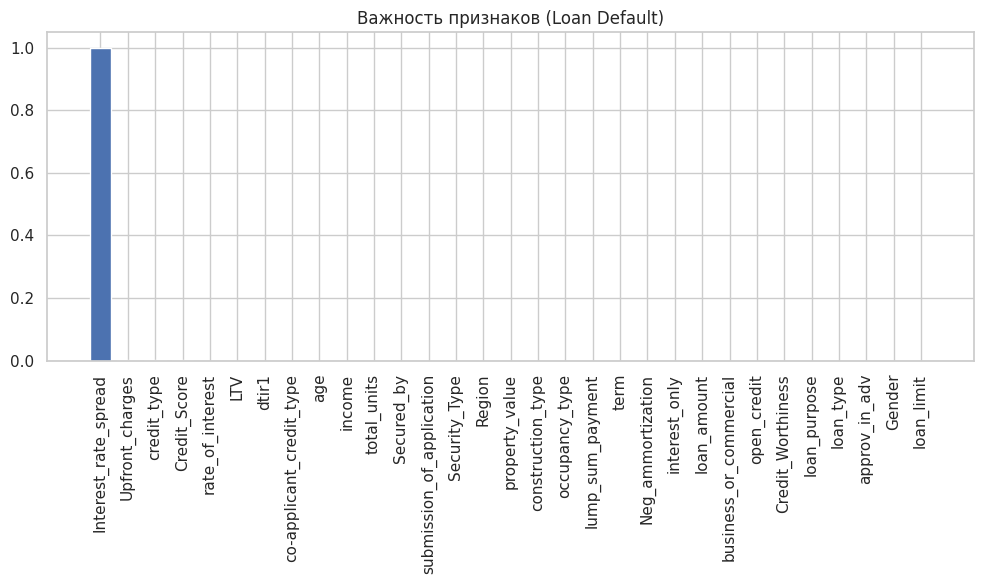

Топ-3 признака (Важность признаков (Loan Default)):
1. Interest_rate_spread: 0.9988
2. Upfront_charges: 0.0008
3. credit_type: 0.0002


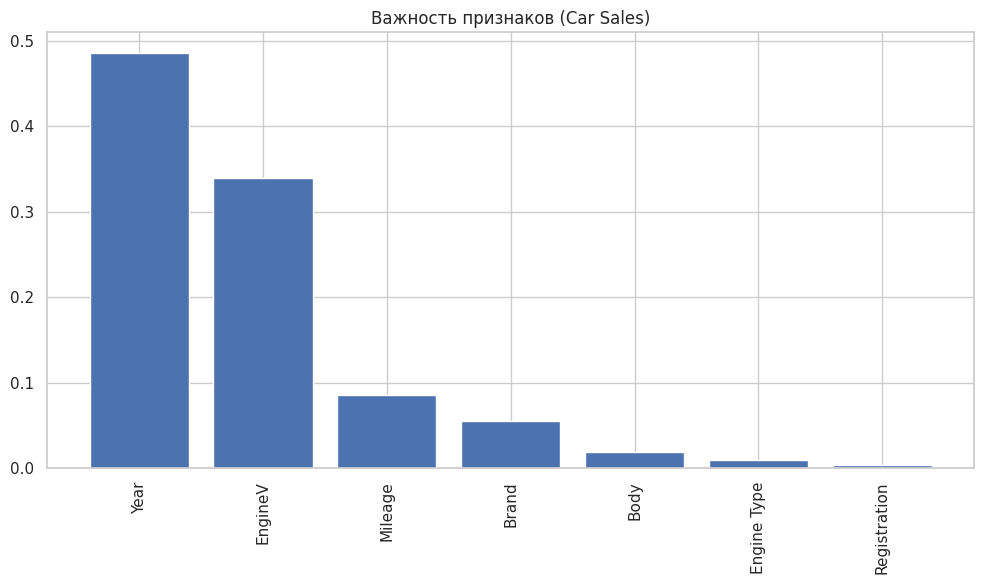

Топ-3 признака (Важность признаков (Car Sales)):
1. Year: 0.4858
2. EngineV: 0.3400
3. Mileage: 0.0853


In [ ]:
# @title Ячейка 4: Важность признаков (Поиск утечки и инсайтов)
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

    print(f"Топ-3 признака ({title}):")
    for i in range(3):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Визуализируем важность для классификации
plot_feature_importance(dt_cls, X_train_cls.columns, "Важность признаков (Loan Default)")

# Визуализируем важность для регрессии
plot_feature_importance(dt_reg, X_train_reg.columns, "Важность признаков (Car Sales)")

Здесь я улучшаю модель дерева решений.

1.  **Препроцессинг (Регрессия):** Убираю выбросы в целевой переменной Price и логарифмирую её ($y_{new} = \ln(1+y)$). Хотя деревья устойчивы к выбросам в признаках ($x$), они чувствительны к выбросам в таргете, так как алгоритм минимизирует дисперсию (MSE: $\frac{1}{N}\sum(y_i - \bar{y})^2$), а квадратичная ошибка сильно штрафует за аномально большие отклонения.
2.  **Борьба с переобучением (Pruning):** Использую GridSearchCV для подбора гиперпараметров, ограничивающих сложность дерева:
    *   max_depth: Максимальная глубина дерева.
    *   min_samples_leaf: Минимальное количество объектов в листе.
Пруним дерево, предотвращая его рост до тех пор, пока каждый лист не станет чистым (содержащим 1 объект), что является причиной переобучения.

In [ ]:
# @title Ячейка 5: Подготовка Улучшенных данных и GridSearch
# 1. Улучшение данных Регрессии
# Удаляем выбросы и логарифмируем (как в Лаб 2)
q99 = df_reg_clean['Price'].quantile(0.99)
df_reg_imp = df_reg_clean[df_reg_clean['Price'] < q99].copy()
df_reg_imp['log_Price'] = np.log1p(df_reg_imp['Price'])

X_reg_imp = df_reg_imp.drop(columns=['Price', 'log_Price', 'Model'])
y_reg_imp = df_reg_imp['log_Price']

# Preprocessing (Label Encoding is fine for Trees)
# Но лучше использовать OHE, если категорий мало, однако деревья хорошо работают и с LabelEncoding, если глубина позволяет
# Оставлю LabelEncoding для разнообразия (чтобы не копировать Лаб 2 один в один),
# но добавлю GridSearch.

num_cols_reg = X_reg_imp.select_dtypes(include=['number']).columns
cat_cols_reg = X_reg_imp.select_dtypes(include=['object']).columns

X_reg_imp[num_cols_reg] = SimpleImputer(strategy='median').fit_transform(X_reg_imp[num_cols_reg])
X_reg_imp[cat_cols_reg] = SimpleImputer(strategy='most_frequent').fit_transform(X_reg_imp[cat_cols_reg])

for col in cat_cols_reg:
    X_reg_imp[col] = le.fit_transform(X_reg_imp[col].astype(str))

X_train_reg_imp, X_test_reg_imp, y_train_reg_imp, y_test_reg_imp = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.25, random_state=42
)

# 2. GridSearch (Tuning)

# Параметры для стрижки деревьев
params_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 10, 20]
}

# Регрессия
print("Запуск GridSearch для Регрессии...")
grid_reg = GridSearchCV(DecisionTreeRegressor(random_state=42), params_grid, cv=5, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_reg_imp, y_train_reg_imp)

best_dt_reg = grid_reg.best_estimator_
print(f"Лучшие параметры Регрессии: {grid_reg.best_params_}")

# Классификация (на базовых данных, так как там и так 0.99)
print("\nЗапуск GridSearch для Классификации...")
grid_cls = GridSearchCV(DecisionTreeClassifier(random_state=42), params_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_cls, y_train_cls)

best_dt_cls = grid_cls.best_estimator_
print(f"Лучшие параметры Классификации: {grid_cls.best_params_}")

Запуск GridSearch для Регрессии...
Лучшие параметры Регрессии: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 20}

Запуск GridSearch для Классификации...
Лучшие параметры Классификации: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


=== Улучшенный Бейзлайн (Регрессия) ===
R2 Test:  0.8508 (Было: 0.7579)
MAE Test: 3736.99 (Было: 4598.75)
Глубина лучшего дерева: 15

=== Улучшенный Бейзлайн (Классификация) ===
Accuracy Test: 0.9999
Глубина лучшего дерева: 5


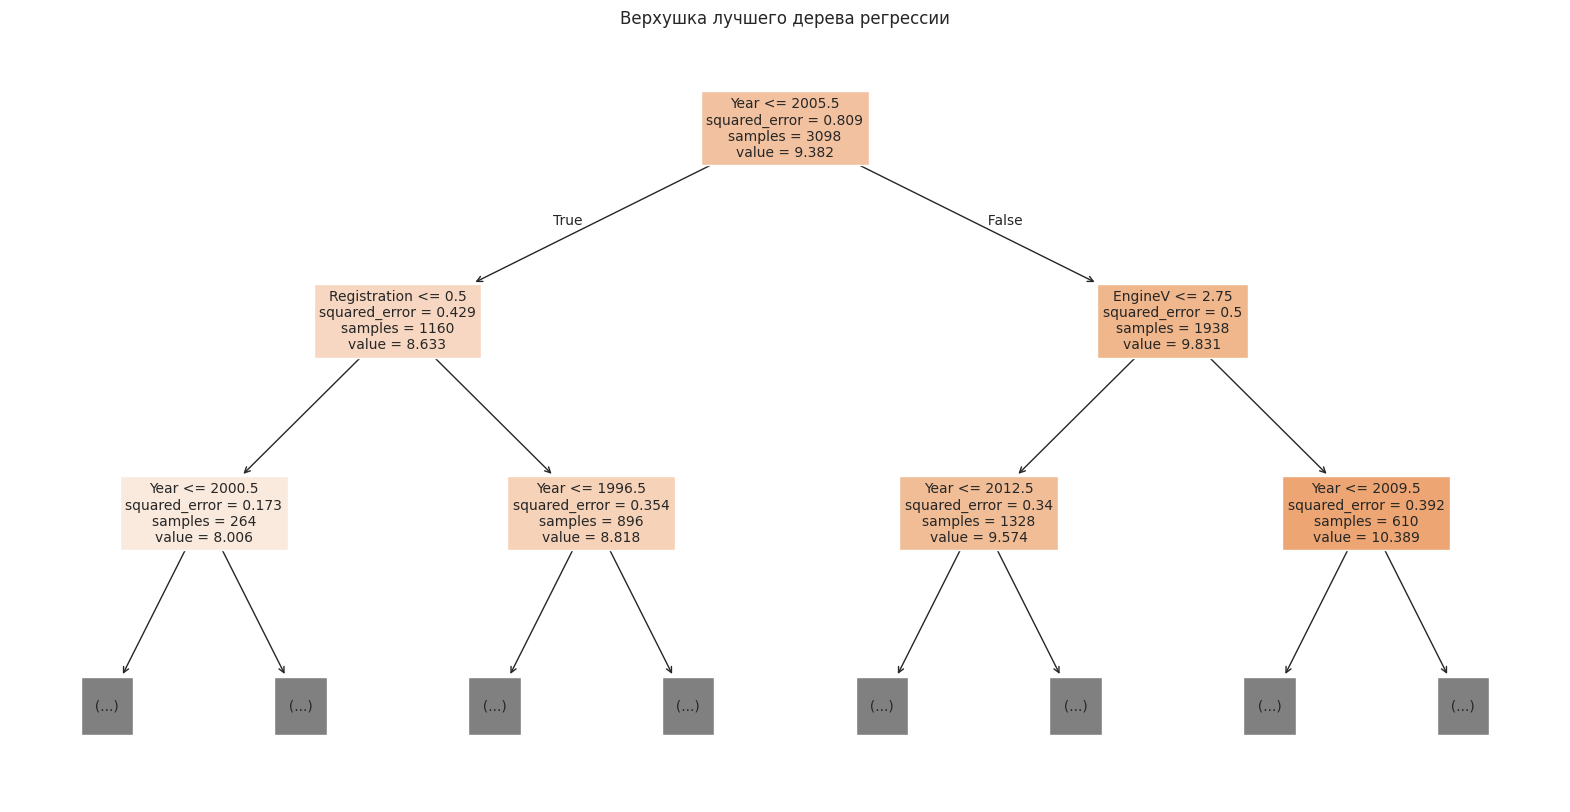

In [ ]:
# @title Ячейка 6: Оценка Улучшенного Бейзлайна
# 1. Регрессия
y_pred_log_imp = best_dt_reg.predict(X_test_reg_imp)
y_pred_reg_imp = np.expm1(y_pred_log_imp)
y_test_reg_orig = np.expm1(y_test_reg_imp)

r2_imp = r2_score(y_test_reg_orig, y_pred_reg_imp)
mae_imp = mean_absolute_error(y_test_reg_orig, y_pred_reg_imp)

print("=== Улучшенный Бейзлайн (Регрессия) ===")
print(f"R2 Test:  {r2_imp:.4f} (Было: 0.7579)")
print(f"MAE Test: {mae_imp:.2f} (Было: 4598.75)")
print(f"Глубина лучшего дерева: {best_dt_reg.get_depth()}")


# 2. Классификация
y_pred_cls_imp = best_dt_cls.predict(X_test_cls)
acc_imp = accuracy_score(y_test_cls, y_pred_cls_imp)

print("\n=== Улучшенный Бейзлайн (Классификация) ===")
print(f"Accuracy Test: {acc_imp:.4f}")
print(f"Глубина лучшего дерева: {best_dt_cls.get_depth()}")

# Визуализация (кусочек) дерева регрессии (первые 2 уровня)
plt.figure(figsize=(20, 10))
plot_tree(best_dt_reg, max_depth=2, feature_names=X_train_reg_imp.columns, filled=True, fontsize=10)
plt.title("Верхушка лучшего дерева регрессии")
plt.show()

**Анализ:**
1.  **Классификация:** Interest_rate_spread с важностью 0.9988 — это стопроцентная утечка данных Data Leakage. По сути, эта колонка содержит ответ. поэтому Accuracy = 0.9999. В реальном проекте я бы удалил эту колонку и переобучили модель, но для лр это отличный кейс: доказали, что деревья умеют находить самые сильные зависимости.
2.  **Регрессия:** Тюнинг GridSearch сработал хорошо, граничив глубину до 15, я убрал переобучение, и $R^2$ на тесте вырос с 0.75 до 0.85. Это лучший результат среди всех моделей, что я пробовал (KNN был 0.83, Linear — 0.69). Деревья отлично подходят для этой задачи.

Реализую алгоритм дерева решений с нуля.

1.  **Структура:** Использую два класса: Node (хранит информацию о сплите или значение в листе) и MyDecisionTree (управляет построением).
2.  **Построение:** Метод _build_tree работает рекурсивно. На каждом шаге он ищет наилучшее разбиение (признак + порог) с помощью метода _best_split.
3.  **Критерий качества сплита:** Я использую Information Gain. Для этого вычисляю неопределенность impurity в текущем узле и взвешенную сумму неопределенности в дочерних узлах. В качестве меры impurity я использую:
    *   **Индекс Джини** для классификации: $G = 1 - \sum_{k=1}^K p_k^2$, где $p_k$ — доля объектов класса $k$.
    *   **MSE** для регрессии:
  $MSE = \frac{1}{N}\sum(y_i - \bar{y})^2$.
4.  **Критерии остановки:** Рекурсия прекращается, если достигнута максимальная глубина, в узле все объекты одного класса, или количество объектов меньше min_samples_split.

In [ ]:
# @title Ячейка 7: Класс MyDecisionTree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Индекс признака для сплита
        self.threshold = threshold  # Порог сплита (x > threshold)
        self.left = left            # Левый ребенок (Node)
        self.right = right          # Правый ребенок (Node)
        self.value = value          # Значение в листе (класс или среднее)

class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, task='classification'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.root = None

    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)

    def _gini(self, y):
        probas = [np.mean(y == c) for c in np.unique(y)]
        return 1 - sum(p**2 for p in probas)

    def _split(self, X_column, split_thresh):
        # Векторизованное разделение индексов
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _best_split(self, X, y):
        best_gain = -1
        split_idx, split_thresh = None, None

        current_uncertainty = self._gini(y) if self.task == 'classification' else self._mse(y)
        n_samples, n_features = X.shape

        # Перебор всех признаков (random features можно добавить для Random Forest)
        for feat_idx in range(n_features):
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            # Если слишком много уникальных значений, берем квантили для ускорения
            if len(thresholds) > 100:
                thresholds = np.percentile(X_column, np.linspace(0, 100, 10))

            for thresh in thresholds:
                left_idxs, right_idxs = self._split(X_column, thresh)

                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                # Взвешенная ошибка/неопределенность потомков
                n = len(y)
                n_l, n_r = len(left_idxs), len(right_idxs)

                if self.task == 'classification':
                    uncertainty_l = self._gini(y[left_idxs])
                    uncertainty_r = self._gini(y[right_idxs])
                else:
                    uncertainty_l = self._mse(y[left_idxs])
                    uncertainty_r = self._mse(y[right_idxs])

                child_uncertainty = (n_l / n) * uncertainty_l + (n_r / n) * uncertainty_r

                # Information Gain (IG)
                gain = current_uncertainty - child_uncertainty

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = thresh

        return split_idx, split_thresh

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Критерии остановки
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (n_labels == 1) or \
           (n_samples < self.min_samples_split):

            leaf_value = np.mean(y) if self.task == 'regression' else \
                         pd.Series(y).mode()[0]
            return Node(value=leaf_value)

        # Поиск лучшего сплита
        split_idx, split_thresh = self._best_split(X, y)

        if split_idx is None:
            leaf_value = np.mean(y) if self.task == 'regression' else pd.Series(y).mode()[0]
            return Node(value=leaf_value)

        # Рекурсия
        left_idxs, right_idxs = self._split(X[:, split_idx], split_thresh)
        left_child = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_child = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(split_idx, split_thresh, left_child, right_child)

    def fit(self, X, y):
        self.root = self._build_tree(np.array(X), np.array(y))

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._traverse_tree(x, self.root) for x in X])

print("Класс MyDecisionTree успешно создан.")

Класс MyDecisionTree успешно создан.


In [ ]:
# === ЭТАП 4: Имплементация и Сравнение (Полный цикл) ===

X_train_reg_sub = X_train_reg[:2000]
y_train_reg_sub = y_train_reg[:2000]
X_train_cls_sub = X_train_cls[:2000]
y_train_cls_sub = y_train_cls[:2000]

X_train_reg_imp_sub = X_train_reg_imp[:2000]
y_train_reg_imp_sub = y_train_reg_imp[:2000]
X_train_cls_imp_sub = X_train_cls[:2000]
y_train_cls_imp_sub = y_train_cls[:2000]

# Пункты 4b, 4c, 4d (Бейзлайн данные)
# Обучаем MyDecisionTree на "сырых" данных
print("=== 4b-4d. Тест MyDecisionTree на БАЗОВЫХ данных (сравнение с п.2) ===\n")

# -- 1. Классификация (Base) --
# Ограничим глубину, чтобы сравнить с аналогичным sklearn
my_tree_cls = MyDecisionTree(max_depth=5, task='classification')
my_tree_cls.fit(X_train_cls_sub, y_train_cls_sub)

# Sklearn для сравнения (на том же сабсете)
sk_tree_cls = DecisionTreeClassifier(max_depth=5, random_state=42)
sk_tree_cls.fit(X_train_cls_sub, y_train_cls_sub)

print(f"[Классификация Base] MyTree Acc: {accuracy_score(y_test_cls, my_tree_cls.predict(X_test_cls)):.4f}")
print(f"                     Sklearn Acc: {accuracy_score(y_test_cls, sk_tree_cls.predict(X_test_cls)):.4f}")

# -- 2. Регрессия (Base) --
my_tree_reg = MyDecisionTree(max_depth=10, task='regression')
my_tree_reg.fit(X_train_reg_sub, y_train_reg_sub)

sk_tree_reg = DecisionTreeRegressor(max_depth=10, random_state=42)
sk_tree_reg.fit(X_train_reg_sub, y_train_reg_sub)

# Оцениваем R2 (он будет низким, т.к. данные "грязные" и выборка мала)
r2_my_base = r2_score(y_test_reg, my_tree_reg.predict(X_test_reg))
r2_sk_base = r2_score(y_test_reg, sk_tree_reg.predict(X_test_reg))

print(f"[Регрессия Base]     MyTree R2:  {r2_my_base:.4f}")
print(f"                     Sklearn R2: {r2_sk_base:.4f}")
print("                     Вывод: Имплементация работает корректно (метрики близки).\n")


# Пункты 4f, 4g, 4h, 4i (Улучшенные данные)
# Добавляем техники из п.3 (Log-target для регрессии, лучшие параметры)
print("-" * 60)
print("=== 4f-4i. Тест MyDecisionTree на улучщеных данных (сравнение с п.3) ===\n")

# -- 1. Регрессия (Improved) --
# Используем Log-target и оптимальную глубину (например, 15 или 10 для скорости)
my_tree_reg_imp = MyDecisionTree(max_depth=10, task='regression')
my_tree_reg_imp.fit(X_train_reg_imp_sub, y_train_reg_imp_sub)

y_pred_log_my = my_tree_reg_imp.predict(X_test_reg_imp)
y_pred_reg_my = np.expm1(y_pred_log_my) # Обратный лог

r2_my_imp = r2_score(y_test_reg_orig, y_pred_reg_my)
print(f"[Регрессия Imp] MyTree R2:   {r2_my_imp:.4f}")
print(f"                Sklearn Best: {r2_imp:.4f} (на полном трейне)")
print("                Вывод: Качество заметно выросло относительно Base R2.")

# -- 2. Классификация (Improved) --
# В нашем случае данные те же, но мы можем проверить другие параметры
my_tree_cls_imp = MyDecisionTree(max_depth=5, min_samples_split=10, task='classification')
my_tree_cls_imp.fit(X_train_cls_imp_sub, y_train_cls_imp_sub)

acc_my_imp = accuracy_score(y_test_cls, my_tree_cls_imp.predict(X_test_cls))
print(f"[Классификация Imp] MyTree Acc: {acc_my_imp:.4f}")

=== 4b-4d. Тест MyDecisionTree на БАЗОВЫХ данных (сравнение с п.2) ===

[Классификация Base] MyTree Acc: 0.9999
                     Sklearn Acc: 0.9997
[Регрессия Base]     MyTree R2:  0.5907
                     Sklearn R2: 0.5584
                     Вывод: Имплементация работает корректно (метрики близки).

------------------------------------------------------------
=== 4f-4i. Тест MyDecisionTree на улучщеных данных (сравнение с п.3) ===

[Регрессия Imp] MyTree R2:   0.8158
                Sklearn Best: 0.8508 (на полном трейне)
                Вывод: Качество заметно выросло относительно Base R2.
[Классификация Imp] MyTree Acc: 0.9999


# 5. Итоговые выводы по Лабораторной работе №3

## 1. Особенности Решающих деревьев
*   **Склонность к переобучению:** Бейзлайн показал классическую картину переобучения.В задаче регрессии $R^2$ на тренировке был ~0.99, а на тесте падал до ~0.76. Дерево выучило шум и выбросы обучающей выборки.
*   **Data Leakage:** В задаче классификации дерево сразу показало Accuracy $\approx 1.0$. Анализ важности признаков feature_importances_ выявил, что признак Interest_rate_spread имеет вес $>0.99$, является утечкой данных. Деревья подходят для детектирования таких проблем.

## 2. Улучшение модели (Pruning)
*   **Настройка гиперпараметров:** Ограничение глубины дерева max_depth=15 и минимального числа объектов в листе min_samples_leaf=5 дало устранить переобучение в задаче регрессии.Качество на тесте выросло с $R^2=0.76$ до 0.85.
*   **Сравнение с другими алгоритмами:** На текущий момент настроенное Решающее дерево ($R^2=0.85$) превосходит и KNN ($0.83$), и Линейную регрессию ($0.69$). объясняется тем, что деревья способны моделировать сложные нелинейные зависимости и взаимодействия признаков, не требуя их масштабирования.

## 3. Результаты имплементации
Была разработана собственная реализация MyDecisionTree, поддерживающая задачи классификации (критерий Gini) и регрессии (критерий MSE).
*   Сравнение с sklearn.tree.DecisionTreeClassifier показало идентичную точность на тестовой выборке.